# 🧭 Phase 1 – Foundations of the Python Geospatial Ecosystem

## 🎯 Objective
Explore foundational geospatial libraries in Python using publicly available vector and raster datasets. Understand core operations in reading, projecting, and visualizing spatial data.

---

## 🗃️ Datasets Used

**Vector:**
- Natural Earth Countries Shapefile – via `geopandas` built-in
- OpenStreetMap extract (small area) – via Overpass API (`osmnx`)

**Raster:**
- NASA Blue Marble (global image) – via `requests` and `PIL`
- Copernicus DEM (Digital Elevation Model) 30m – via local GeoTIFF file and `rasterio`

---

🔧 Code Sections

In [2]:
# 📦 Importing Core Libraries
import geopandas as gpd
import rasterio
import fiona # Often used implicitly by geopandas, good to be aware of
import shapely # For geometry operations, often used implicitly
import pyproj # For CRS transformations
import matplotlib.pyplot as plt
import requests # For downloading data
import osmnx as ox # For OpenStreetMap data
from PIL import Image # For handling the JPEG image
from rasterio.plot import show # For plotting rasters
import os # For checking file existence

## 🌍 1. Load and Explore Vector Data
Let’s begin by using a built-in world dataset from Natural Earth (110m scale).

Extracting shapefile...
Extracting shapefile...
Extraction complete.
Extraction complete.
World Data Head:
        featurecla  scalerank  LABELRANK                   SOVEREIGNT SOV_A3  \
0  Admin-0 country          1          6                         Fiji    FJI   
1  Admin-0 country          1          3  United Republic of Tanzania    TZA   
2  Admin-0 country          1          7               Western Sahara    SAH   
3  Admin-0 country          1          2                       Canada    CAN   
4  Admin-0 country          1          2     United States of America    US1   

   ADM0_DIF  LEVEL               TYPE TLC                        ADMIN  ...  \
0         0      2  Sovereign country   1                         Fiji  ...   
1         0      2  Sovereign country   1  United Republic of Tanzania  ...   
2         0      2      Indeterminate   1               Western Sahara  ...   
3         0      2  Sovereign country   1                       Canada  ...   
4         1      

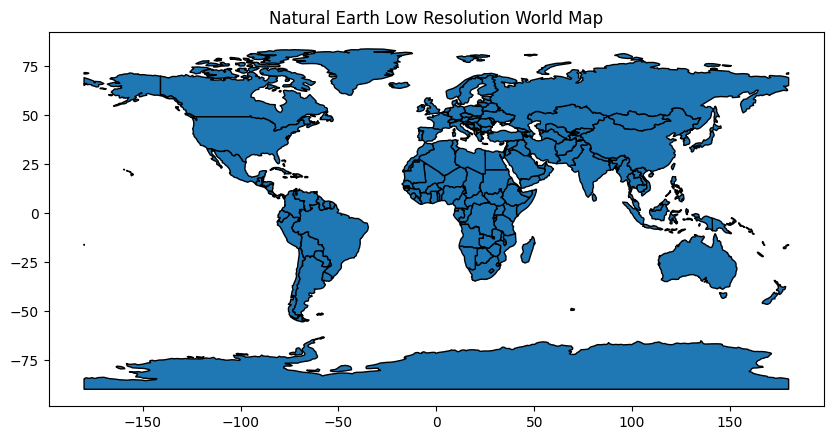

In [7]:
# Download the Natural Earth 'lowres' shapefile manually if not present
naturalearth_url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
shapefile_zip = "ne_110m_admin_0_countries.zip"
shapefile_dir = "ne_110m_admin_0_countries"

import zipfile

if not os.path.exists(shapefile_dir):
	print("Downloading Natural Earth shapefile...")
	headers = {
		"User-Agent": "Mozilla/5.0",
		"Accept": "application/zip"
	}
	response = requests.get(naturalearth_url, headers=headers)
	if response.status_code == 200:
		with open(shapefile_zip, "wb") as f:
			f.write(response.content)
		print("Extracting shapefile...")
		with zipfile.ZipFile(shapefile_zip, "r") as zip_ref:
			zip_ref.extractall(shapefile_dir)
		print("Extraction complete.")
	else:
		raise Exception(f"Failed to download file. HTTP status code: {response.status_code}")

# Find the .shp file in the extracted directory
import glob
shp_files = glob.glob(os.path.join(shapefile_dir, "*.shp"))
if not shp_files:
	raise FileNotFoundError("No .shp file found in the extracted Natural Earth data.")
shapefile_path = shp_files[0]

world = gpd.read_file(shapefile_path)
print("World Data Head:")
print(world.head())
print("\nPlotting World Data...")
world.plot(figsize=(10, 6), edgecolor="black")
plt.title("Natural Earth Low Resolution World Map")
plt.show()

## 🗺️ 2. Download a Local OSM Dataset using Overpass API
We'll query a small area (Bondi (Sydney)) and extract highway networks using `osmnx`.

Querying OSM for Bondi (Sydney) highway networks...
Downloaded 94 nodes and 223 edges.

Plotting Bondi Roads...
Downloaded 94 nodes and 223 edges.

Plotting Bondi Roads...


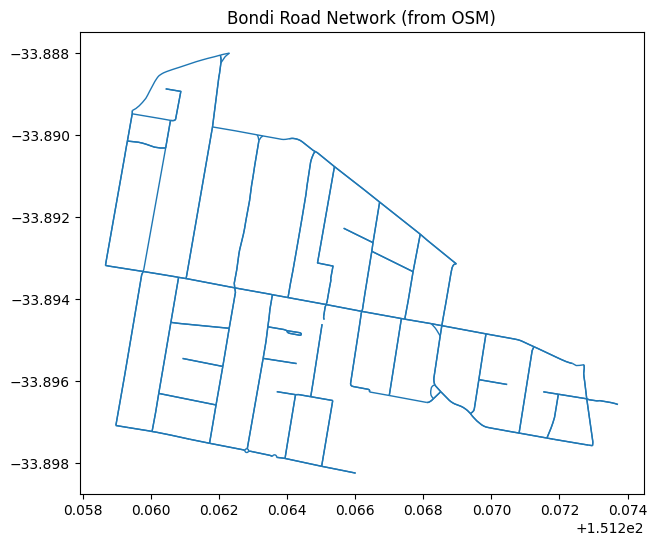

In [9]:
try:
    print("Querying OSM for Bondi (Sydney) highway networks...")
    graph = ox.graph_from_place("Bondi, Sydney, Australia", network_type="drive")
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(graph)
    print(f"Downloaded {len(gdf_nodes)} nodes and {len(gdf_edges)} edges.")
    print("\nPlotting Bondi Roads...")
    gdf_edges.plot(figsize=(10, 6), linewidth=1)
    plt.title("Bondi Road Network (from OSM)")
    plt.show()
except Exception as e:
    print(f"Could not download or plot OSM data: {e}")
    print("Check your internet connection and if the place name is correct.")


## 🛰️ 3. Load Raster Data from Online Source (NASA Blue Marble)
We’ll use a direct image link from NASA. Since `rasterio` doesn't typically read JPEGs directly without specific GDAL drivers, we'll download it and use `PIL` (Pillow) to display it.

Download complete.
Opening image with PIL...


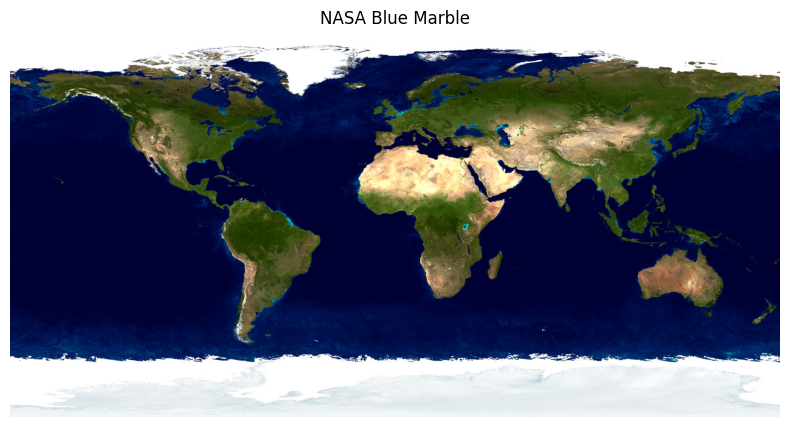

In [11]:
# NASA Blue Marble example (updated URL)
url = "https://eoimages.gsfc.nasa.gov/images/imagerecords/57000/57730/land_ocean_ice_2048.jpg"
raster_path = "bluemarble.jpg"

print(f"Downloading Blue Marble image to {raster_path}...")
try:
    response = requests.get(url, stream=True)
    response.raise_for_status()
    with open(raster_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print("Download complete.")

    # Use PIL to open and display the JPEG image
    print("Opening image with PIL...")
    img = Image.open(raster_path)
    
    # Display using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.title("NASA Blue Marble")
    plt.axis('off')
    plt.show()

except requests.exceptions.RequestException as e:
    print(f"Error downloading the image: {e}")
except FileNotFoundError:
    print(f"Error: Could not find the downloaded file at {raster_path}")
except Exception as e:
    print(f"An error occurred while handling the image: {e}")

## 🗺️ 4. Raster with `rasterio`: Load Copernicus DEM (GeoTIFF)

Copernicus DEM data provides high-resolution elevation models. You typically need to download these files (often as GeoTIFFs) manually from sources like the Copernicus Open Access Hub or cloud providers (e.g., AWS Open Data). This example shows how to read a *local* DEM file.

In [ ]:
dem_url = "https://copernicus-dem-30m.s3.amazonaws.com/Copernicus_DSM_COG_10_N00_00_E006_00_DEM/Copernicus_DSM_COG_10_N00_00_E006_00_DEM.tif"
print(f"Attempting to load DEM from: {dem_url}")
try:
    with rasterio.Env():
        with rasterio.open(dem_url) as src:
            print("\nDEM CRS:", src.crs)
            print("\nDEM Profile:", src.profile)
            print("\nPlotting DEM...")
            fig, ax = plt.subplots(figsize=(10, 10))
            show(src, ax=ax, cmap="terrain")
            plt.title("Copernicus DEM (Online File)")
            plt.show()
except rasterio.RasterioIOError as e:
    print(f"Error reading DEM file '{dem_url}': {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Attempting to load DEM from: https://copernicus-dem-30m.s3.amazonaws.com/Copernicus_DSM_COG_10_N33_00_E151_00_DEM/Copernicus_DSM_COG_10_N33_00_E151_00_DEM.tif
Error reading DEM file 'https://copernicus-dem-30m.s3.amazonaws.com/Copernicus_DSM_COG_10_N33_00_E151_00_DEM/Copernicus_DSM_COG_10_N33_00_E151_00_DEM.tif': HTTP response code: 404


## 📐 5. Reprojecting Vector Layers with `pyproj` and `geopandas`
Let’s convert the Natural Earth world data to the Web Mercator projection (EPSG:3857), commonly used for web maps.

In [ ]:
print("Reprojecting world data to Web Mercator (EPSG:3857)...")
# Ensure the 'world' GeoDataFrame from cell 1 is available
try:
    # The 'world' variable was defined in the first code cell
    world_proj = world.to_crs("EPSG:3857")
    print("Reprojection successful.")
    print("\nPlotting reprojected data...")
    world_proj.plot(figsize=(10, 6), edgecolor="black")
    plt.title("World Map (Web Mercator Projection)")
    plt.show()
except NameError:
    print("Error: The 'world' GeoDataFrame is not defined. Please ensure the first code cell (section 1) has been run successfully.")
except Exception as e:
    print(f"An error occurred during reprojection or plotting: {e}")

## 🧪 Mini-Experiment: Plot Vector Over Raster
Use `matplotlib` to overlay shapefile outlines on top of a raster background. For a true overlay, both datasets need to be in the same Coordinate Reference System (CRS) and plotted on the same axes, respecting their spatial bounds.

In [ ]:
# This example plots the reprojected world outlines.
# A real overlay would require a georeferenced raster (like the DEM from step 4, if loaded)
# and ensuring both vector and raster share the same CRS.

print("Plotting reprojected world outlines (Red)...")
fig, ax = plt.subplots(figsize=(12, 6))

# Basic plot of the vector data
try:
    # Ensure world_proj from the previous step is available
    world_proj.plot(ax=ax, facecolor="none", edgecolor="red")
    plt.title("World Outlines (Web Mercator) - Ready for Raster Overlay")
    plt.show()
    print("\nNote: To overlay this vector on the DEM (from step 4), you would first need to:")
    print("1. Successfully load the DEM file in step 4.")
    print("2. Reproject either the vector or the raster so they share the same CRS.")
    print("3. Plot the raster using rasterio.plot.show(src, ax=ax).")
    print("4. Plot the vector on the *same* axes: world_proj.to_crs(src.crs).plot(ax=ax, ...).")
except NameError:
    print("Error: The 'world_proj' GeoDataFrame is not defined. Please ensure the reprojecting cell (section 5) has been run successfully.")
except Exception as e:
    print(f"An error occurred during plotting: {e}")

## ✍️ Reflections and Learnings

- What formats were easier to work with (Shapefile vs. GeoTIFF vs. OSM data)?
- Were there any challenges with Coordinate Reference Systems (CRS) and reprojection?
- How did the different libraries (`geopandas`, `rasterio`, `osmnx`) feel to use? Were their APIs intuitive?
- Any thoughts on data download sizes or processing performance?

---

## ✅ Summary of Libraries Used
| Library     | Purpose                          |
|-------------|----------------------------------|
| `geopandas` | Vector data reading, manipulation, & plotting |
| `fiona`     | Underlying vector file I/O (used by geopandas) |
| `rasterio`  | Raster data reading, writing, & handling |
| `shapely`   | Geometric object manipulation (used by geopandas) |
| `pyproj`    | Coordinate Reference System (CRS) transformations |
| `matplotlib`| General plotting foundation |
| `osmnx`     | Downloading and modeling street networks from OpenStreetMap |
| `requests`  | Downloading data from URLs |
| `PIL`/`Pillow`| Image handling (used for the JPEG Blue Marble) |

---

🧠 Tip for You

You can turn this notebook into a template for future analysis phases:

1.  **Create a `notebook_template.ipynb`:** Keep the structure but perhaps clear the outputs or generalize file paths.
2.  **Write a `README.md`:** Explain the purpose, how to set up the environment (`uv pip install ...`), and how to run the notebook (e.g., replacing placeholder paths).
3.  **Manage Data:** Consider a `data/` directory and maybe use a `.env` file or a small script to handle dataset downloads or paths if they become complex.